In [0]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [3]:
!mkdir datafaces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2020-05-03 16:51:53--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.33
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  21.4MB/s    in 66s     

2020-05-03 16:52:59 (20.9 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [0]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("datafaces/")

In [5]:
root = 'datafaces/img_align_celeba/'
img_list = os.listdir(root)
print(len(img_list))

202599


In [6]:
from PIL import Image
from tqdm import tqdm

total_img = 10000

orig_width = 178
orig_height = 208
diff = (orig_height - orig_width) // 2

width = 128
height = 128

crop_rect = (0, diff, orig_width, orig_height - diff)

images = []
for pic_file in tqdm(os.listdir(root)[:total_img]):
    pic = Image.open(root + pic_file).crop(crop_rect)
    pic.thumbnail((width, height), Image.ANTIALIAS)
    images.append(np.uint8(pic))

images = np.array(images) / 255
images.shape


100%|██████████| 10000/10000 [00:16<00:00, 608.49it/s]


(10000, 128, 128, 3)

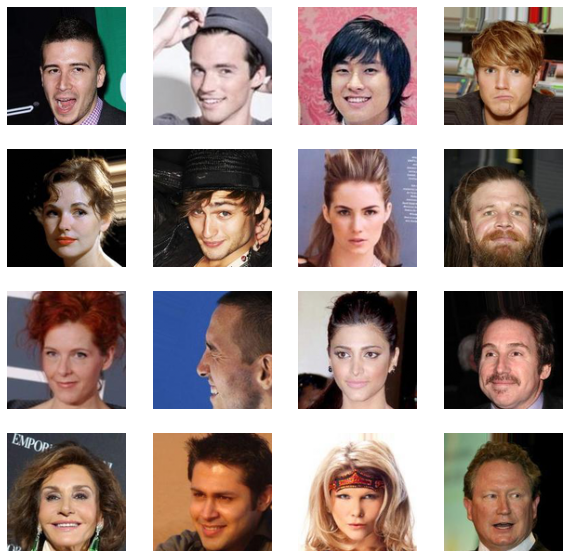

In [7]:
plt.figure(1, figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [0]:
latent_dim = 32
channels = 3

def create_generator():
    gen_input = Input(shape=(latent_dim, ))
    
    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)
    
    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(channels, 7, activation='tanh', padding='same')(x)
    
    generator = Model(gen_input, x)
    return generator

In [0]:
def create_discriminator():
    disc_input = Input(shape=(height, width, channels))
    
    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)
    
    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8)
    
    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy')
    
    return discriminator

In [0]:
generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False

gan_input = Input(shape=(latent_dim, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [0]:
import time

iters = 38000
batch_size = 16

RES_DIR = 'res'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

control_size_sqrt = 6
control_vectors = np.random.normal(size=(control_size_sqrt**2, latent_dim)) / 2

In [12]:
start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    generated = generator.predict(latent_vectors)
    
    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])
    
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)
    
    latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)
    
    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0
    
    if step % 50 == 49:
        gan.save_weights('gan.h5')
        
        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))
        control_image = np.zeros((width * control_size_sqrt, height * control_size_sqrt, channels))
        control_generated = generator.predict(control_vectors)
        for i in range(control_size_sqrt ** 2):
            x_off = i % control_size_sqrt
            y_off = i // control_size_sqrt
            control_image[x_off * width:(x_off + 1) * width, y_off * height:(y_off + 1) * height, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


50/38000: d_loss: 0.6644,  a_loss: 0.9377.  (1.1 sec)
100/38000: d_loss: 0.6735,  a_loss: 0.7577.  (1.1 sec)
150/38000: d_loss: 0.6635,  a_loss: 0.6989.  (1.1 sec)
200/38000: d_loss: 0.6364,  a_loss: 1.3377.  (1.0 sec)
250/38000: d_loss: 0.7018,  a_loss: 1.4618.  (1.1 sec)
300/38000: d_loss: 0.6224,  a_loss: 1.2349.  (1.0 sec)
350/38000: d_loss: 0.6480,  a_loss: 0.9721.  (1.0 sec)
400/38000: d_loss: 0.6395,  a_loss: 1.0699.  (1.1 sec)
450/38000: d_loss: 0.7536,  a_loss: 0.9397.  (1.1 sec)
500/38000: d_loss: 0.6493,  a_loss: 1.0067.  (1.0 sec)
550/38000: d_loss: 0.6480,  a_loss: 1.2833.  (1.1 sec)
600/38000: d_loss: 0.7597,  a_loss: 0.8291.  (1.0 sec)
650/38000: d_loss: 0.7100,  a_loss: 1.6975.  (1.1 sec)
700/38000: d_loss: 0.8206,  a_loss: 1.6681.  (1.1 sec)
750/38000: d_loss: 0.6150,  a_loss: 0.9431.  (1.1 sec)
800/38000: d_loss: 0.7278,  a_loss: 0.7063.  (1.1 sec)
850/38000: d_loss: 0.6942,  a_loss: 0.9479.  (1.1 sec)
900/38000: d_loss: 0.6855,  a_loss: 0.8516.  (1.1 sec)
950/38000: 

In [15]:
import imageio
import shutil

images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('training_visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 42506, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [16]:
from google.colab import files
files.download( "training_visual.gif" )    

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 35108, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil